In [1]:
import numpy as np
import pandas as pd
import scipy
from scipy import stats
import datetime as dt

import matplotlib.pyplot as plt
from matplotlib import colors
import soundfile as sf
import matplotlib.patches as patches

In [2]:
import sys

sys.path.append("../src")

In [3]:
from core import SITE_NAMES, FREQ_GROUPS

In [4]:
def plot_ipi_hist(site_key, freq_key, fig_details):
    site_name = SITE_NAMES[site_key]
    location_sum_df = pd.read_csv(f'../data/2022_bd2_summary/{site_key}/bd2__{freq_key}{site_key}_2022.csv', index_col=0)
    intervals = (pd.to_datetime(location_sum_df['call_start_time'].values[1:]) - pd.to_datetime(location_sum_df['call_end_time'].values[:-1]))
    valid_intervals = intervals[intervals < pd.Timedelta(hours=12)]
    ipis_ms = valid_intervals.to_numpy(dtype='float32')/1e6
    plt.rcParams.update({'font.size' : 20})
    plt.figure(figsize=(12, 6))
    plt.title(f"Frequency histogram for {freq_key.split('_')[0].upper()} inter-pulse intervals {site_name} (bin size = {fig_details['bin_step']})", loc='left', fontsize=20)
    histogram = plt.hist(ipis_ms, bins=np.arange(fig_details['time_start'], fig_details['time_end']+fig_details['bin_step'], fig_details['bin_step']), facecolor='y', edgecolor='k')
    plt.grid(axis='y')
    bin_ticks = np.arange(fig_details['time_start'], fig_details['time_end']+fig_details['bin_step'], fig_details['bin_step']).round(3)
    bin_labels = bin_ticks.astype('str')

    for i in range(1, fig_details['i_end']):
        bin_labels[i::fig_details['i_end']] = ' '

    plt.xticks(bin_ticks, bin_labels, rotation=45)
    plt.ylabel('# of intervals', fontsize=20)
    plt.xlabel('Time (ms)', loc='left', fontsize=20)
    plt.xlim(fig_details['time_start'], fig_details['time_end'])
    plt.tight_layout()
    plt.show()

    return ipis_ms, histogram


In [5]:
fig_details = dict()
fig_details['time_start'] = 0
fig_details['bin_step'] = 10
fig_details['i_end'] = 100
fig_details['time_end'] = 10000

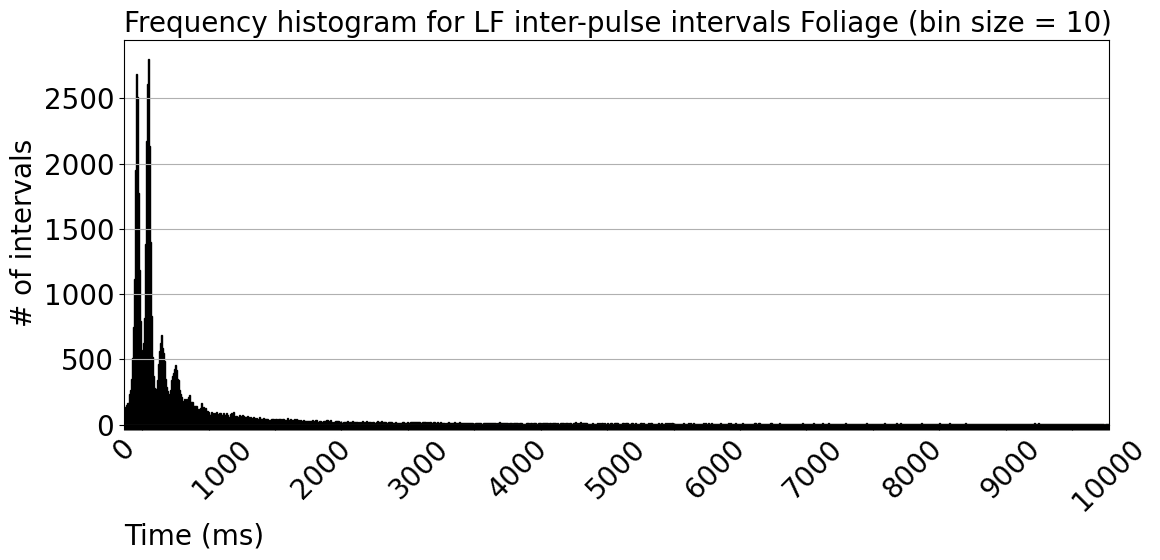

In [6]:
site_key = 'Foliage'
freq_key = 'lf_'
ipis_f, hist_f = plot_ipi_hist(site_key, freq_key, fig_details)

In [7]:
print(hist_f[1][:-1])
print(hist_f[0])

[   0.   10.   20.   30.   40.   50.   60.   70.   80.   90.  100.  110.
  120.  130.  140.  150.  160.  170.  180.  190.  200.  210.  220.  230.
  240.  250.  260.  270.  280.  290.  300.  310.  320.  330.  340.  350.
  360.  370.  380.  390.  400.  410.  420.  430.  440.  450.  460.  470.
  480.  490.  500.  510.  520.  530.  540.  550.  560.  570.  580.  590.
  600.  610.  620.  630.  640.  650.  660.  670.  680.  690.  700.  710.
  720.  730.  740.  750.  760.  770.  780.  790.  800.  810.  820.  830.
  840.  850.  860.  870.  880.  890.  900.  910.  920.  930.  940.  950.
  960.  970.  980.  990. 1000. 1010. 1020. 1030. 1040. 1050. 1060. 1070.
 1080. 1090. 1100. 1110. 1120. 1130. 1140. 1150. 1160. 1170. 1180. 1190.
 1200. 1210. 1220. 1230. 1240. 1250. 1260. 1270. 1280. 1290. 1300. 1310.
 1320. 1330. 1340. 1350. 1360. 1370. 1380. 1390. 1400. 1410. 1420. 1430.
 1440. 1450. 1460. 1470. 1480. 1490. 1500. 1510. 1520. 1530. 1540. 1550.
 1560. 1570. 1580. 1590. 1600. 1610. 1620. 1630. 16

In [8]:
def get_histogram(site_key, freq_key, fig_details):
    location_sum_df = pd.read_csv(f'../data/2022_bd2_summary/{site_key}/bd2__{freq_key}{site_key}_2022.csv', index_col=0)
    intervals = (pd.to_datetime(location_sum_df['call_start_time'].values[1:]) - pd.to_datetime(location_sum_df['call_end_time'].values[:-1]))
    valid_intervals = intervals[intervals < pd.Timedelta(hours=12)]
    ipis_ms = valid_intervals.to_numpy(dtype='float32')/1e6
    hist_loc = np.histogram(ipis_ms, bins=np.arange(fig_details['time_start'], ipis_ms.max()+fig_details['bin_step'], fig_details['bin_step']))

    return ipis_ms, hist_loc

def plot_log_survival(site_key, freq_key, fig_details):
    site_name = SITE_NAMES[site_key]
    ipis_loc, hist_loc = get_histogram(site_key, freq_key, fig_details)
    values, base = hist_loc[0], hist_loc[1]
    cumulative = (np.cumsum(values[-1::-1]))[-1::-1]
    survival = np.log(cumulative)
    intervals_ms = base[:-1]
    print(intervals_ms)
    intervals_s = np.divide(intervals_ms, 1000).astype('int')
    intervals_min = np.divide(intervals_s, 60).astype('int')


    plt.figure(figsize=(12, 4))
    plt.rcParams.update({'font.size' : 20})
    plt.title(f"Log-survivorship curve in {site_name}", fontsize=20)
    plt.plot(intervals_ms, survival, marker='.', c='navy')
    plt.ylabel('log(# of intervals)', fontsize=18)
    plt.xlabel('Time (min)', fontsize=18)
    plt.xticks(intervals_ms[::60000], intervals_min[::60000], rotation=45)
    print(intervals_ms)
    plt.grid(which='both')
    plt.xlim(0, fig_details['time_end'])
    plt.show()

In [9]:
site_name = SITE_NAMES[site_key]
print(f'Looking at {site_name}')

Looking at Foliage


In [10]:
location_sum_df = pd.read_csv(f'../data/2022_bd2_summary/{site_key}/bd2__{freq_key}{site_key}_2022.csv', index_col=0)
intervals = (pd.to_datetime(location_sum_df['call_start_time'].values[1:]) - pd.to_datetime(location_sum_df['call_end_time'].values[:-1]))
valid_intervals = intervals[intervals < pd.Timedelta(hours=12)]
ipis_loc = valid_intervals.to_numpy(dtype='float32')/1e6
hist_loc = np.histogram(ipis_loc, bins=np.arange(fig_details['time_start'], ipis_loc.max()+fig_details['bin_step'], fig_details['bin_step']))
values, base = hist_loc[0], hist_loc[1]
values # values are # of intervals of increasing length from shortest interval to longest interval

array([ 52, 133, 151, ...,   0,   0,   1])

In [11]:
values[::-1] # Set values to accumulate from interval with longest interval to shortest interval

array([  1,   0,   0, ..., 151, 133,  52])

In [12]:
values[range(max(values.argmax()-31, 0), values.argmax()+31)]

array([  52,  133,  151,  165,  165,  233,  263,  348,  507,  751, 1119,
       1954, 2683, 2508, 1771, 1187,  790,  570,  506,  473,  623,  814,
       1383, 2170, 2612, 2804, 2135, 1399,  831,  519,  370,  281,  271,
        270,  339,  465,  564,  628,  684,  587,  549,  485,  353,  285,
        255,  232,  213,  265,  339,  369,  398,  423,  460,  422,  347,
        343])

In [13]:
(np.cumsum(values[::-1])) # Set values to accumulate from interval with longest interval to shortest interval

array([    1,     1,     1, ..., 66830, 66963, 67015])

In [14]:
(np.cumsum(values[-1::-1]))[-1::-1] # Set cumulation to start from total intervals and decrease

array([67015, 66963, 66830, ...,     1,     1,     1])

In [15]:
cumulative = (np.cumsum(values[-1::-1]))[-1::-1]
survival = np.log(cumulative)
intervals_ms = base[:-1]
intervals_s = np.divide(intervals_ms, 1000).astype('int')
intervals_min = np.divide(intervals_s, 60).astype('int')

values[-1], intervals_ms[-1] # The last data point with frequency of 1

(1, 31839930.0)

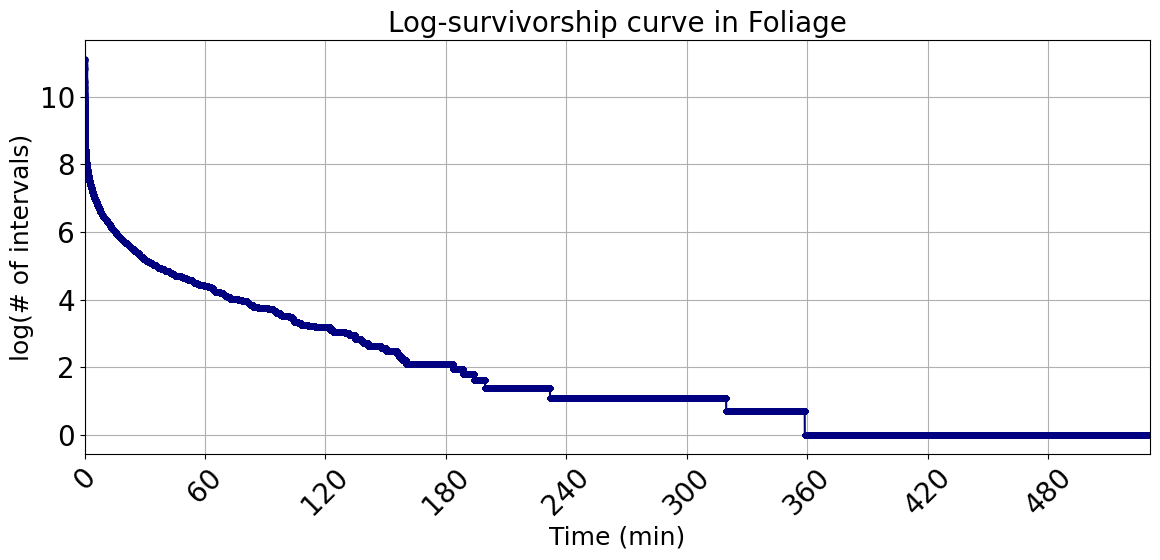

In [16]:
plt.figure(figsize=(12, 6))
plt.rcParams.update({'font.size' : 20})
plt.title(f"Log-survivorship curve in {site_name}", fontsize=20)
plt.plot(intervals_ms, survival, marker='.', c='navy')
plt.ylabel('log(# of intervals)', fontsize=18)
plt.xlabel('Time (min)', fontsize=18)
plt.xticks(intervals_ms[::360000], intervals_min[::360000], rotation=45)
plt.grid(which='both')
plt.xlim(0, intervals_ms[-1])

plt.tight_layout()
plt.show()

In [17]:
# fast_inds = np.logical_and(survival >= (survival.max() * 0.90), survival <= (survival.max() * 1.0))
# fast_inds = survival >= 8
fast_inds = range(max(values.argmax()-31, 0), values.argmax()+31)
fast_start = int(intervals_ms[fast_inds][0])
fast_end = int(intervals_ms[fast_inds][-1])

fast_coeff = stats.linregress(intervals_ms[fast_inds], survival[fast_inds])
print(f'Considering points from {intervals_ms[fast_inds][0]} to {intervals_ms[fast_inds][-1]} for fast process')

Considering points from 0.0 to 550.0 for fast process


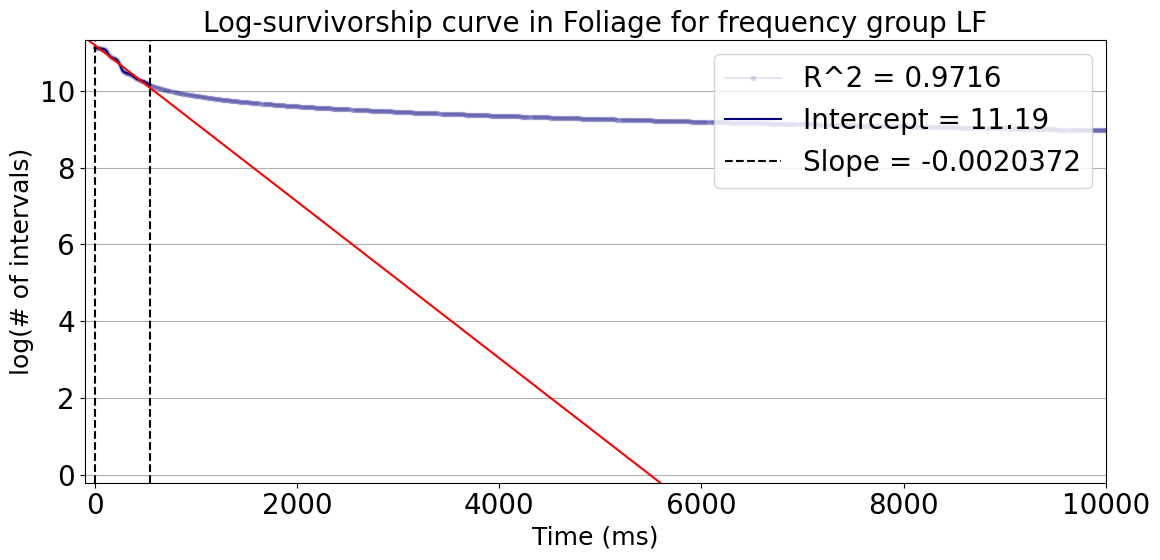

In [18]:
plt.figure(figsize=(12, 6))
if freq_key:
    plt.title(f"Log-survivorship curve in {site_name} for frequency group {freq_key.split('_')[0].upper()}", fontsize=20)
else:
    plt.title(f"Log-survivorship curve in {site_name} for all frequency groups", fontsize=20)
plt.plot(intervals_ms, survival, marker='.', c='navy', alpha=0.1)
plt.plot(intervals_ms[fast_inds], survival[fast_inds], c='navy')
plt.axvline(fast_start, linestyle='dashed', color='k')
plt.axvline(fast_end, linestyle='dashed', color='k')

x = np.linspace(-100, fig_details['time_end'])
plt.plot(x, fast_coeff.intercept + fast_coeff.slope*x, c='red', marker=None)

plt.grid(axis='y')
plt.ylabel('log(# of intervals)', fontsize=18)
plt.xlabel('Time (ms)', fontsize=18)
plt.xlim(intervals_ms[0]-100, fig_details['time_end'])
plt.ylim(survival[-1]-0.2, survival[0]+0.2)
plt.tight_layout()
plt.legend([f"R^2 = {round(fast_coeff.rvalue**2, 4)}", f"Intercept = {round(fast_coeff.intercept, 2)}", f"Slope = {round(fast_coeff.slope, 8)}"], loc='upper right')

plt.show()

In [19]:
fast_process = dict()
fast_process['lambda'] = -1*fast_coeff.slope
fast_process['num_intervals_sibly'] = np.exp(fast_coeff.intercept) / fast_process['lambda']

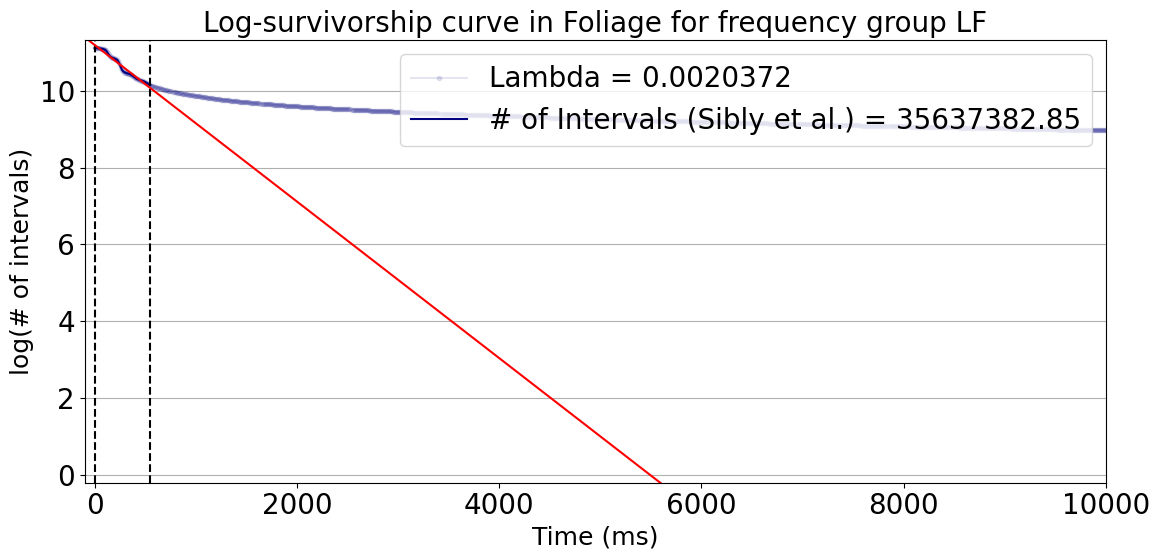

In [20]:
plt.figure(figsize=(12, 6))
if freq_key:
    plt.title(f"Log-survivorship curve in {site_name} for frequency group {freq_key.split('_')[0].upper()}", fontsize=20)
else:
    plt.title(f"Log-survivorship curve in {site_name} for all frequency groups", fontsize=20)
plt.plot(intervals_ms, survival, marker='.', c='navy', alpha=0.1)
plt.plot(intervals_ms[fast_inds], survival[fast_inds], c='navy')
plt.axvline(fast_start, linestyle='dashed', color='k')
plt.axvline(fast_end, linestyle='dashed', color='k')

x = np.linspace(-100, fig_details['time_end'])
plt.plot(x, fast_coeff.intercept + fast_coeff.slope*x, c='red', marker=None)

plt.grid(axis='y')
plt.ylabel('log(# of intervals)', fontsize=18)
plt.xlabel('Time (ms)', fontsize=18)
plt.xlim(intervals_ms[0]-100, fig_details['time_end'])
plt.ylim(survival[-1]-0.2, survival[0]+0.2)
plt.tight_layout()
plt.legend([f"Lambda = {round(fast_process['lambda'], 8)}", f"# of Intervals (Sibly et al.) = {round(fast_process['num_intervals_sibly'], 2)}"], loc='upper right')

plt.show()

In [21]:
slow_inds = np.logical_and(survival >= (survival.max() * 0.30), survival <= (survival.max() * 0.40))
# slow_inds = range(18000, 72001)
slow_start = int(intervals_ms[slow_inds][0])
slow_end = int(intervals_ms[slow_inds][-1])

slow_coeff = stats.linregress(intervals_ms[slow_inds], survival[slow_inds])
print(f'Considering points from {intervals_ms[slow_inds][0]} to {intervals_ms[slow_inds][-1]} for slow process')

Considering points from 3422860.0 to 6265250.0 for slow process


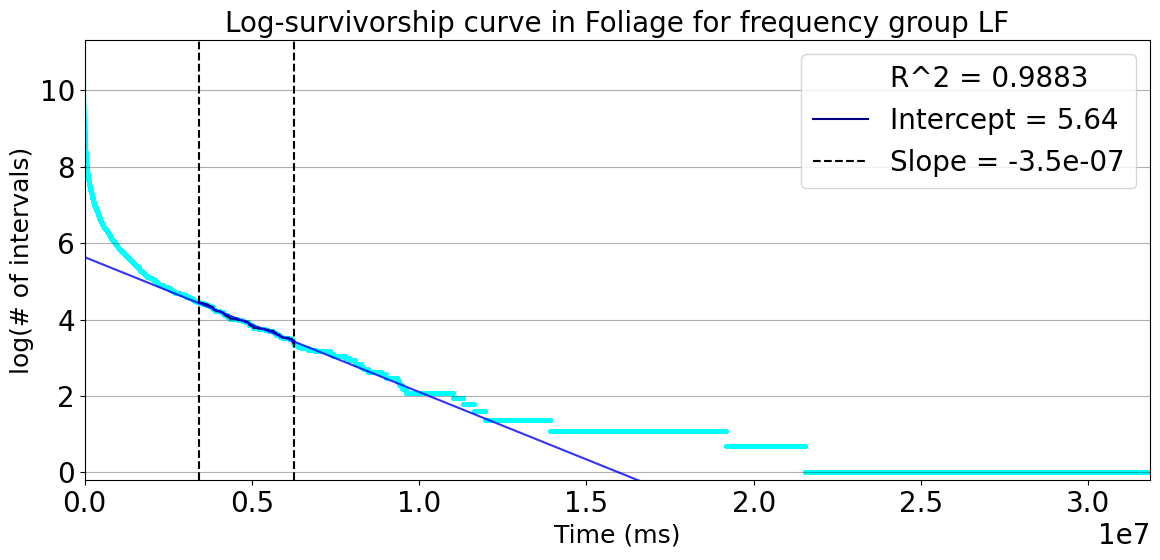

In [22]:
plt.figure(figsize=(12, 6))
if freq_key:
    plt.title(f"Log-survivorship curve in {site_name} for frequency group {freq_key.split('_')[0].upper()}", fontsize=20)
else:
    plt.title(f"Log-survivorship curve in {site_name} for all frequency groups", fontsize=20)
plt.plot(intervals_ms, survival, marker='.', c='cyan', alpha=0.002)
plt.plot(intervals_ms[slow_inds], survival[slow_inds], c='navy')
plt.axvline(slow_start, linestyle='dashed', color='k')
plt.axvline(slow_end, linestyle='dashed', color='k')

x = np.linspace(-100, intervals_ms[-1], slow_end)
plt.plot(x, slow_coeff.intercept + slow_coeff.slope*x, c='blue', marker=None, alpha=0.8, label=f"R^2 = {round(slow_coeff.rvalue**2, 4)}")

plt.grid(axis='y')
plt.ylabel('log(# of intervals)', fontsize=18)
plt.xlabel('Time (ms)', fontsize=18)
plt.xlim(intervals_ms[0], intervals_ms[-1])
plt.ylim(survival[-1]-0.2, survival[0]+0.2)
plt.tight_layout()
plt.legend([f"R^2 = {round(slow_coeff.rvalue**2, 4)}", f"Intercept = {round(slow_coeff.intercept, 2)}", f"Slope = {round(slow_coeff.slope, 8)}"], loc='upper right')

plt.show()

In [23]:
slow_process = dict()
slow_process['lambda'] = -1*slow_coeff.slope
slow_process['num_intervals_sibly'] = np.exp(slow_coeff.intercept) / slow_process['lambda']

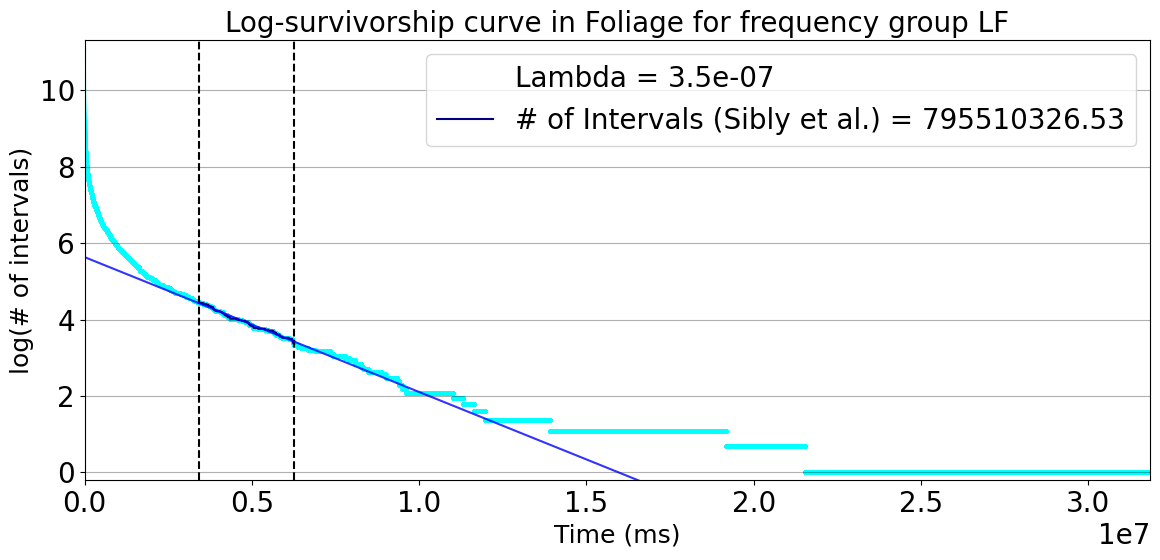

In [24]:
plt.figure(figsize=(12, 6))
if freq_key:
    plt.title(f"Log-survivorship curve in {site_name} for frequency group {freq_key.split('_')[0].upper()}", fontsize=20)
else:
    plt.title(f"Log-survivorship curve in {site_name} for all frequency groups", fontsize=20)
plt.plot(intervals_ms, survival, marker='.', c='cyan', alpha=0.002)
plt.plot(intervals_ms[slow_inds], survival[slow_inds], c='navy')
plt.axvline(slow_start, linestyle='dashed', color='k')
plt.axvline(slow_end, linestyle='dashed', color='k')

x = np.linspace(-100, intervals_ms[-1], slow_end)
plt.plot(x, slow_coeff.intercept + slow_coeff.slope*x, c='blue', marker=None, alpha=0.8, label=f"R^2 = {round(slow_coeff.rvalue**2, 4)}")

plt.grid(axis='y')
plt.ylabel('log(# of intervals)', fontsize=18)
plt.xlabel('Time (ms)', fontsize=18)
plt.xlim(intervals_ms[0], intervals_ms[-1])
plt.ylim(survival[-1]-0.2, survival[0]+0.2)
plt.tight_layout()
plt.legend([f"Lambda = {round(slow_process['lambda'], 8)}", f"# of Intervals (Sibly et al.) = {round(slow_process['num_intervals_sibly'], 2)}"], loc='upper right')

plt.show()

In [25]:
bci = (1/(fast_process['lambda'] - slow_process['lambda'])) * np.log((fast_process['num_intervals_sibly']*fast_process['lambda'])/(slow_process['num_intervals_sibly']*slow_process['lambda']))
ratio_of_fast_to_slow = (fast_process['num_intervals_sibly']/slow_process['num_intervals_sibly'])

print(fast_process['num_intervals_sibly']*fast_process['lambda'] > slow_process['num_intervals_sibly']*slow_process['lambda'])

misassigned_points = (fast_process['num_intervals_sibly']*np.exp(-1*fast_process['lambda']*bci)) + (slow_process['num_intervals_sibly']*(1 - np.exp(-1*slow_process['lambda']*bci)))

print(f'Fast process features: {fast_process}')
print(f'Slow process features: {slow_process}')
print(f'Bout criterion interval = {bci}')
print(f'Ratio of # of fast intervals to # of slow intervals = {ratio_of_fast_to_slow}')
print(f'# of points misassigned: {misassigned_points}')

True
Fast process features: {'lambda': 0.0020371960647568134, 'num_intervals_sibly': 35637382.84786224}
Slow process features: {'lambda': 3.5315469058182955e-07, 'num_intervals_sibly': 795510326.5294226}
Bout criterion interval = 2727.0586626924833
Ratio of # of fast intervals to # of slow intervals = 0.04479813983476199
# of points misassigned: 903537.7609206397


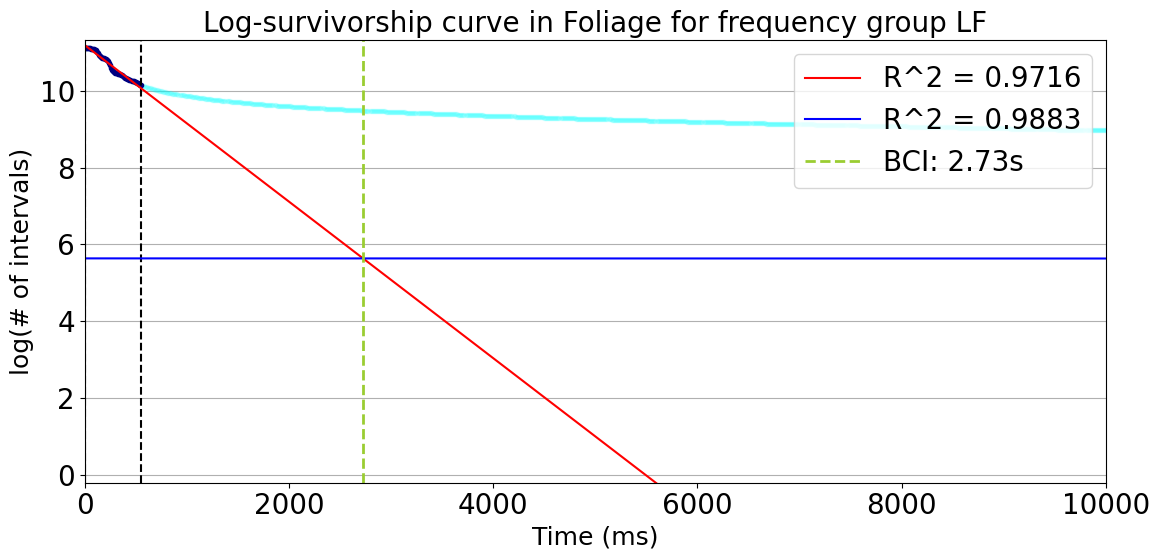

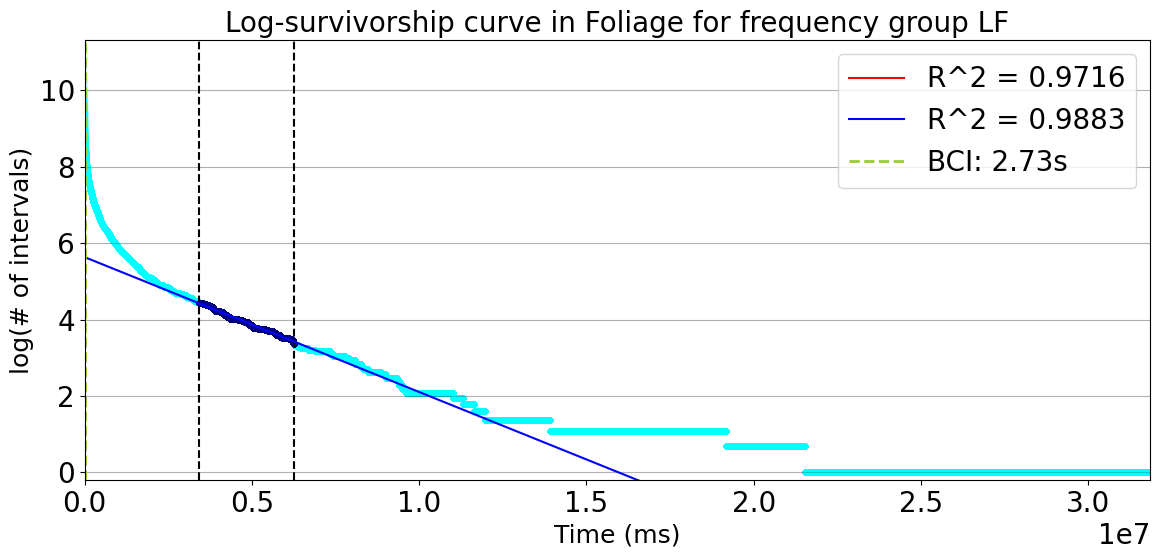

In [26]:
# when going from 10min to 20min for slow: 1078835.2447705253
# when going from 30min to 60min for slow: 525720.475054683
# when going from 10min to 30min for slow: 1001108.3657059798
# when going from 10min to 60min for slow: 762398.8879568598
# when going from 15min to 45min for slow: 792437.7460185888
# when going from >85% and 30%-15% for slow: 637558.2284707666


plt.figure(figsize=(12, 6))
if freq_key:
    plt.title(f"Log-survivorship curve in {site_name} for frequency group {freq_key.split('_')[0].upper()}", fontsize=20)
else:
    plt.title(f"Log-survivorship curve in {site_name} for all frequency groups", fontsize=20)
plt.plot(intervals_ms, survival, marker='.', c='cyan', alpha=0.1)
plt.plot(intervals_ms[fast_inds], survival[fast_inds], marker='.', c='navy')
plt.axvline(fast_start, linestyle='dashed', color='k')
plt.axvline(fast_end, linestyle='dashed', color='k')
x = np.linspace(-100, intervals_ms[-1], slow_end)
plt.plot(x, fast_coeff.intercept + fast_coeff.slope*x, c='red', marker=None, label=f"R^2 = {round(fast_coeff.rvalue**2, 4)}")
plt.plot(x, slow_coeff.intercept + slow_coeff.slope*x, c='blue', marker=None, label=f"R^2 = {round(slow_coeff.rvalue**2, 4)}")
plt.axvline(bci, linestyle='dashed', linewidth=2, color='yellowgreen', label=f"BCI: {round(bci/1000, 2)}s")
plt.grid(axis='y')
plt.ylabel('log(# of intervals)', fontsize=18)
plt.xlabel('Time (ms)', fontsize=18)
plt.xlim(intervals_ms[0], fig_details['time_end'])
plt.ylim(survival[-1]-0.2, survival[0]+0.2)
plt.tight_layout()

plt.legend(loc='upper right')

plt.figure(figsize=(12, 6))
if freq_key:
    plt.title(f"Log-survivorship curve in {site_name} for frequency group {freq_key.split('_')[0].upper()}", fontsize=20)
else:
    plt.title(f"Log-survivorship curve in {site_name} for all frequency groups", fontsize=20)
plt.plot(intervals_ms, survival, marker='.', alpha=0.02, c='cyan')
plt.plot(intervals_ms[slow_inds], survival[slow_inds], marker='.', c='navy')
plt.axvline(slow_start, linestyle='dashed', color='k')
plt.axvline(slow_end, linestyle='dashed', color='k')
x = np.linspace(-100, intervals_ms[-1], slow_end)
plt.plot(x, fast_coeff.intercept + fast_coeff.slope*x, c='red', marker=None, label=f"R^2 = {round(fast_coeff.rvalue**2, 4)}")
plt.plot(x, slow_coeff.intercept + slow_coeff.slope*x, c='blue', marker=None, label=f"R^2 = {round(slow_coeff.rvalue**2, 4)}")
plt.axvline(bci, linestyle='dashed', linewidth=2, color='yellowgreen', label=f"BCI: {round(bci/1000, 2)}s")
plt.grid(axis='y')
plt.ylabel('log(# of intervals)', fontsize=18)
plt.xlabel('Time (ms)', fontsize=18)
plt.xlim(intervals_ms[0], intervals_ms[-1])
plt.ylim(survival[-1]-0.2, survival[0]+0.2)
plt.tight_layout()

plt.legend(loc='upper right')
plt.show()

In [27]:
-1*slow_process['lambda']*ipis_loc.max()

-11.244422746225256

In [28]:
num_bouts = slow_process['num_intervals_sibly']*(1 - np.exp(-1*slow_process['lambda']*ipis_loc.max()))
avg_bout_length = (slow_process['num_intervals_sibly'] + fast_process['num_intervals_sibly']) / num_bouts

num_bouts, avg_bout_length

(795499921.21829, 1.0448118060205476)

In [29]:
location_df = pd.read_csv('../batdetect2_outputs/recover-20210912/Foliage/bd2_20210910_030000.csv')
file_dts = pd.to_datetime(location_df['input_file'], format='%Y%m%d_%H%M%S', exact=False)

anchor_start_times = file_dts + pd.to_timedelta(location_df['start_time'].values.astype('float64'), unit='S') # type: ignore
anchor_end_times = file_dts + pd.to_timedelta(location_df['end_time'].values.astype('float64'), unit='S') # type: ignore

location_df.insert(0, 'call_end_time', anchor_end_times)
location_df.insert(0, 'call_start_time', anchor_start_times)
location_df.insert(0, 'ref_time', anchor_start_times)

location_df = location_df.loc[(location_df["high_freq"]).astype('float64') < FREQ_GROUPS[freq_key][1]]
location_df = location_df.loc[(location_df["low_freq"]).astype('float64') > FREQ_GROUPS[freq_key][0]]

intervals = (pd.to_datetime(location_df['call_start_time'].values[1:]) - pd.to_datetime(location_df['call_end_time'].values[:-1]))
ipis_f = intervals.to_numpy(dtype='float32')/1e6

bouts = np.ones(len(ipis_f))
bouts[ipis_f < bci] = 0
bouts[ipis_f > 1000*3600*12] = 12
bouts = np.insert(bouts, 0, 1)

bout_start_inds = np.where(bouts==1)[0]
left_point_to_starts = np.subtract(bout_start_inds, 1)
left_point_to_starts = left_point_to_starts[left_point_to_starts > 0]
bouts[left_point_to_starts] = -1
bout_end_inds = np.where(bouts==-1)[0]
right_point_to_ends = bouts[np.add(bout_end_inds, 1)]
inds_with_no_bouts_to_right = bout_end_inds[np.where(right_point_to_ends==-1)[0]]
bouts[np.add(bout_end_inds[np.where(right_point_to_ends==-1)[0]], 1)] = -2
bouts[np.where(bouts==-1)] = 2
bouts[np.where(bouts==-2)] = -1

bouts = bouts.astype('str')
bouts[bouts=="1.0"] = 'bout start'
bouts[bouts=="2.0"] = 'bout end'
bouts[bouts=="0.0"] = 'within bout'
bouts[bouts=='12.0'] = "no next call within 12 hours"

location_df['call_status'] = bouts
batdetect2_predictions = location_df
batdetect2_predictions

,ref_time,call_start_time,call_end_time,start_time,end_time,low_freq,high_freq,event,class,class_prob,det_prob,individual,input_file,Recover Folder,SD Card,Site name,call_status
0,2021-09-10 03:04:06.932500,2021-09-10 03:04:06.932500,2021-09-10 03:04:06.941800,246.9325,246.9418,28046.0,37602.0,Echolocation,Eptesicus serotinus,0.402,0.549,-1,/Users/adityakrishna/Documents/Research/Lab_re...,recover-20210912_unit2,UBNA_002,Foliage,bout start
1,2021-09-10 03:04:07.216500,2021-09-10 03:04:07.216500,2021-09-10 03:04:07.226400,247.2165,247.2264,28046.0,38133.0,Echolocation,Eptesicus serotinus,0.415,0.573,-1,/Users/adityakrishna/Documents/Research/Lab_re...,recover-20210912_unit2,UBNA_002,Foliage,within bout
2,2021-09-10 03:04:07.352500,2021-09-10 03:04:07.352500,2021-09-10 03:04:07.362700,247.3525,247.3627,28046.0,38892.0,Echolocation,Eptesicus serotinus,0.422,0.555,-1,/Users/adityakrishna/Documents/Research/Lab_re...,recover-20210912_unit2,UBNA_002,Foliage,within bout
3,2021-09-10 03:04:07.471500,2021-09-10 03:04:07.471500,2021-09-10 03:04:07.479400,247.4715,247.4794,27187.0,42404.0,Echolocation,Eptesicus serotinus,0.546,0.763,-1,/Users/adityakrishna/Documents/Research/Lab_re...,recover-20210912_unit2,UBNA_002,Foliage,within bout
4,2021-09-10 03:04:07.590500,2021-09-10 03:04:07.590500,2021-09-10 03:04:07.600100,247.5905,247.6001,28046.0,37383.0,Echolocation,Eptesicus serotinus,0.376,0.530,-1,/Users/adityakrishna/Documents/Research/Lab_re...,recover-20210912_unit2,UBNA_002,Foliage,within bout
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3206,2021-09-10 03:29:41.446500,2021-09-10 03:29:41.446500,2021-09-10 03:29:41.456500,1781.4465,1781.4565,25468.0,32664.0,Echolocation,Nyctalus leisleri,0.273,0.584,-1,/Users/adityakrishna/Documents/Research/Lab_re...,recover-20210912_unit2,UBNA_002,Foliage,within bout
3207,2021-09-10 03:29:41.578500,2021-09-10 03:29:41.578500,2021-09-10 03:29:41.589100,1781.5785,1781.5891,26328.0,32298.0,Echolocation,Nyctalus leisleri,0.328,0.577,-1,/Users/adityakrishna/Documents/Research/Lab_re...,recover-20210912_unit2,UBNA_002,Foliage,within bout
3208,2021-09-10 03:29:41.938500,2021-09-10 03:29:41.938500,2021-09-10 03:29:41.947700,1781.9385,1781.9477,26328.0,34069.0,Echolocation,Eptesicus serotinus,0.294,0.614,-1,/Users/adityakrishna/Documents/Research/Lab_re...,recover-20210912_unit2,UBNA_002,Foliage,within bout
3209,2021-09-10 03:29:42.061500,2021-09-10 03:29:42.061500,2021-09-10 03:29:42.070200,1782.0615,1782.0702,25468.0,34393.0,Echolocation,Eptesicus serotinus,0.393,0.600,-1,/Users/adityakrishna/Documents/Research/Lab_re...,recover-20210912_unit2,UBNA_002,Foliage,within bout


In [30]:
end_times_of_bouts = batdetect2_predictions['call_end_time'].loc[batdetect2_predictions['call_status']=='bout end']
start_times_of_bouts = batdetect2_predictions['call_start_time'].loc[batdetect2_predictions['call_status']=='bout start']
end_times = batdetect2_predictions['end_time'].loc[batdetect2_predictions['call_status']=='bout end']
start_times = batdetect2_predictions['start_time'].loc[batdetect2_predictions['call_status']=='bout start']
if len(start_times_of_bouts) != len(end_times_of_bouts):
    start_times_of_bouts = start_times_of_bouts[:-1]
    start_times = start_times[:-1]
if len(start_times_of_bouts) != len(end_times_of_bouts):
    start_times_of_bouts = start_times_of_bouts[1:]
    start_times = start_times[1:]
bout_durations = pd.to_timedelta(end_times_of_bouts.values - start_times_of_bouts.values, unit='ns') # type:ignore

bout_metrics = pd.DataFrame()
bout_metrics['start_time_of_bout'] = start_times_of_bouts.values
bout_metrics['end_time_of_bout'] = end_times_of_bouts.values
bout_metrics['start_time'] = start_times.values
bout_metrics['end_time'] = end_times.values
bout_metrics['bout_duration'] = end_times_of_bouts.values - start_times_of_bouts.values # type:ignore
bout_metrics['bout_duration_in_secs'] = bout_metrics['bout_duration'].apply(lambda x : x.total_seconds())
bout_metrics

,start_time_of_bout,end_time_of_bout,start_time,end_time,bout_duration,bout_duration_in_secs
0,2021-09-10 03:04:06.932500000,2021-09-10 03:04:19.103500,246.9325,259.1035,0 days 00:00:12.171000,12.1710
1,2021-09-10 03:07:43.450500000,2021-09-10 03:07:53.411500,463.4505,473.4115,0 days 00:00:09.961000,9.9610
2,2021-09-10 03:09:36.077500000,2021-09-10 03:09:44.096400,576.0775,584.0964,0 days 00:00:08.018900,8.0189
3,2021-09-10 03:10:01.776500000,2021-09-10 03:10:19.494600,601.7765,619.4946,0 days 00:00:17.718100,17.7181
4,2021-09-10 03:11:05.946500000,2021-09-10 03:11:49.168400,665.9465,709.1684,0 days 00:00:43.221900,43.2219
5,2021-09-10 03:12:06.501499999,2021-09-10 03:12:33.388800,726.5015,753.3888,0 days 00:00:26.887300001,26.8873
6,2021-09-10 03:12:40.928500000,2021-09-10 03:13:23.141200,760.9285,803.1412,0 days 00:00:42.212700,42.2127
7,2021-09-10 03:13:39.513499999,2021-09-10 03:13:43.399400,819.5135,823.3994,0 days 00:00:03.885900001,3.8859
8,2021-09-10 03:13:49.487500000,2021-09-10 03:14:57.960500,829.4875,897.9605,0 days 00:01:08.473000,68.4730
9,2021-09-10 03:15:01.849500000,2021-09-10 03:15:48.188200,901.8495,948.1882,0 days 00:00:46.338700,46.3387


40824.0


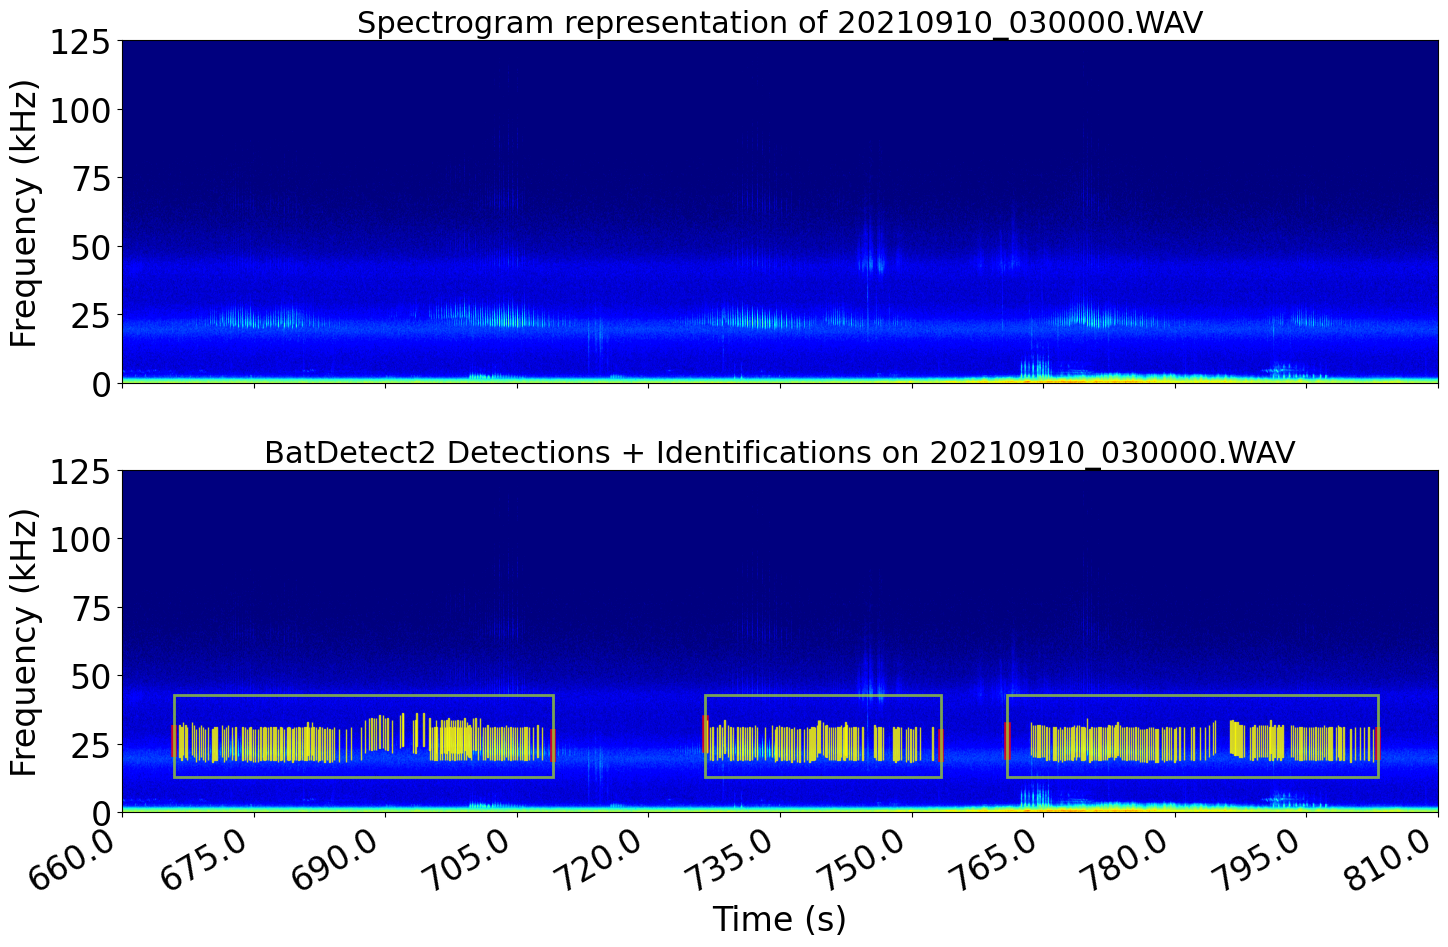

In [35]:
audio_file = sf.SoundFile('../../Documents/Research/Lab_related/example/original_recording/recover-20210912_unit2/UBNA_002/20210910_030000.WAV')
fs = audio_file.samplerate
start = 660
duration = 810 - start
audio_file.seek(int(fs*start))
audio_seg = audio_file.read(int(fs*duration))
vmin = 20*np.log10(np.max(audio_seg)) - 55 # hide anything below -rm_dB dB

plt.figure(figsize=(15, 10))
plt.subplot(211)
plt.title("Spectrogram representation of 20210910_030000.WAV", fontsize=22)
plt.rcParams.update({'font.size': 24})
plt.specgram(audio_seg, NFFT=1024, cmap='jet', vmin=vmin)
plt.yticks(ticks=np.linspace(0, 1, 6), labels=np.linspace(0, fs/2000, 6).astype('int'))
plt.xticks(ticks=np.linspace(0, duration*(fs/2), 11), labels=np.round(np.linspace(start, start+duration, 11, dtype='float'), 2), rotation=30)
plt.ylabel("Frequency (kHz)")
# plt.xlabel("Time (s)")

plt.subplot(212)
plt.title("BatDetect2 Detections + Identifications on 20210910_030000.WAV", fontsize=22)
plt.rcParams.update({'font.size': 24})
plt.specgram(audio_seg, NFFT=1024, cmap='jet', vmin=vmin) # type:ignore
plot_dets = batdetect2_predictions.loc[np.logical_and(batdetect2_predictions['start_time'] > start, batdetect2_predictions['end_time'] < (start+duration))]

print(plot_dets['high_freq'].max())
ax = plt.gca()
for i, row in plot_dets.iterrows():
    if row['call_status'] != 'within bout' and row['call_status'] != '-1.0':
        # if row['call_status'] == 'bout end':
        #     plt.text(x=(row['start_time'] - start - duration/30)*(fs/2), y=(row['low_freq']+18000)/(fs/2), s=f"{row['call_status'].upper()}", color='yellow', fontsize=12)
        # else:
        #     plt.text(x=(row['start_time'] - start - duration/100)*(fs/2), y=(row['low_freq']+18000)/(fs/2), s=f"{row['call_status'].upper()}", color='yellow', fontsize=12)
        rect = patches.Rectangle(((row['start_time'] - start - 0.01)*(fs/2), (row['low_freq']-2000)/(fs/2)), 
                    0.04*(fs/2), 12000/(fs/2), linewidth=4, edgecolor='red', facecolor='none', alpha=0.8)
    else:
        rect = patches.Rectangle(((row['start_time'] - start - 0.01)*(fs/2), (row['low_freq']-2000)/(fs/2)), 
                    0.04*(fs/2), 12000/(fs/2), linewidth=1, edgecolor='yellow', facecolor='none', alpha=0.8)
    
    ax.add_patch(rect)

plot_dets = bout_metrics.loc[np.logical_and(bout_metrics['start_time'] > start, bout_metrics['end_time'] < (start+duration))]
ax = plt.gca()
for i, row in plot_dets.iterrows():
    
    rect = patches.Rectangle(((row['start_time'] - start)*(fs/2), (FREQ_GROUPS[freq_key][0])/(fs/2)), 
                    (row['bout_duration_in_secs'])*(fs/2), (FREQ_GROUPS[freq_key][1] - FREQ_GROUPS[freq_key][0])/(fs/2), linewidth=2, edgecolor='yellowgreen', facecolor='none', alpha=0.8)
    
    ax.add_patch(rect)

plt.yticks(ticks=np.linspace(0, 1, 6), labels=np.linspace(0, fs/2000, 6).astype('int'))
plt.xticks(ticks=np.linspace(0, duration*(fs/2), 11), labels=np.round(np.linspace(start, start+duration, 11, dtype='float'), 2), rotation=30)
plt.ylabel("Frequency (kHz)")
plt.xlabel("Time (s)")
plt.gcf().autofmt_xdate()

plt.tight_layout()
plt.show()

In [32]:
def model(t, f_intervals, f_lambda, s_intervals, s_lambda):
    return (np.log((f_intervals*f_lambda*np.exp(-1*f_lambda*t))  + (s_intervals*s_lambda*np.exp(-1*s_lambda*t))))

In [33]:
x0 = np.array([fast_process['num_intervals_sibly'], fast_process['lambda'], slow_process['num_intervals_sibly'], slow_process['lambda']], dtype='float64')
print("Using nonlinear curve-fitting to optimize process estimates")
cfit_sols = scipy.optimize.curve_fit(model, intervals_ms[:1800].astype('float64'), survival[:1800].astype('float64'), p0=x0)
cfit_sols[0]
optim_x = cfit_sols[0]
optim_bci = (1/(optim_x[1] - optim_x[3])) * np.log((optim_x[0]*optim_x[1])/(optim_x[2]*optim_x[3]))
ratio_of_fast_to_slow_optim = optim_x[0]/optim_x[2]

misassigned_points_optim = (optim_x[0]*np.exp(-1*optim_x[1]*optim_bci)) + (optim_x[2]*(1 - np.exp(-1*optim_x[3]*optim_bci)))

print(f'Optimal fast process features: lambda={optim_x[1]}, num_intervals={optim_x[0]}')
print(f'Optimal slow process features: lambda={optim_x[3]}, num_intervals={optim_x[2]}')
print(f'Optimal bout criterion interval = {optim_bci}')
print(f'Optimal ratio of # of fast intervals to # of slow intervals = {ratio_of_fast_to_slow_optim}')
print(f'# of points misassigned: {misassigned_points_optim}')
print(f"Optim BCI has less misassignments than BCI? {misassigned_points_optim < misassigned_points}")

Using nonlinear curve-fitting to optimize process estimates
Optimal fast process features: lambda=0.0018662528896655364, num_intervals=24110748.065592814
Optimal slow process features: lambda=5.12808990467748e-05, num_intervals=267083041.19449815
Optimal bout criterion interval = 655.3641885151952
Optimal ratio of # of fast intervals to # of slow intervals = 0.09027435047077594
# of points misassigned: 15923244.15692161
Optim BCI has less misassignments than BCI? False


/var/folders/qj/4txkrxcn2ld7mby9_6n6npnr0000gn/T/ipykernel_32775/2494304720.py:2: RuntimeWarning: invalid value encountered in log
  return (np.log((f_intervals*f_lambda*np.exp(-1*f_lambda*t))  + (s_intervals*s_lambda*np.exp(-1*s_lambda*t))))


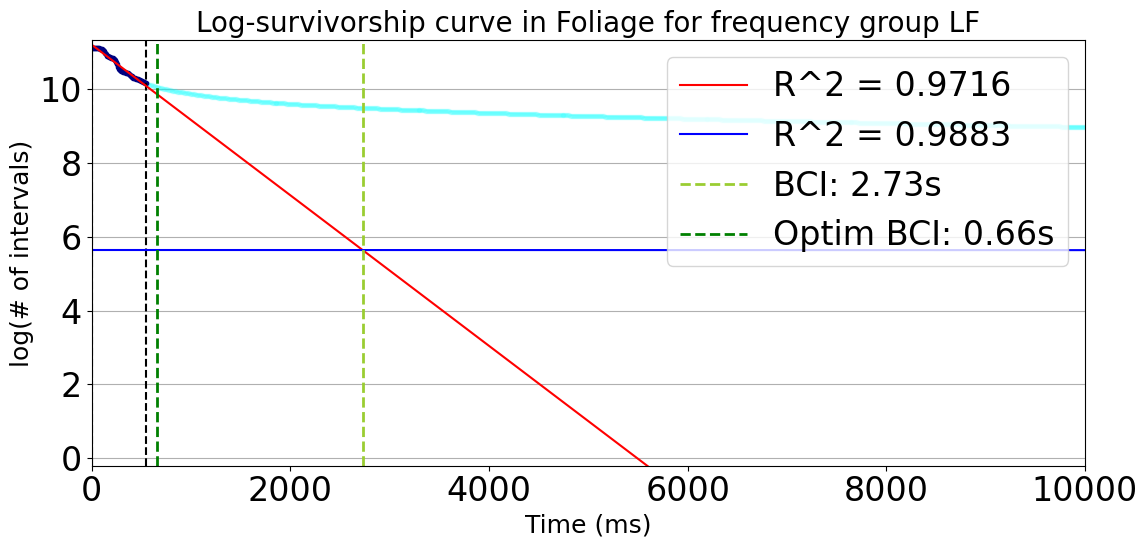

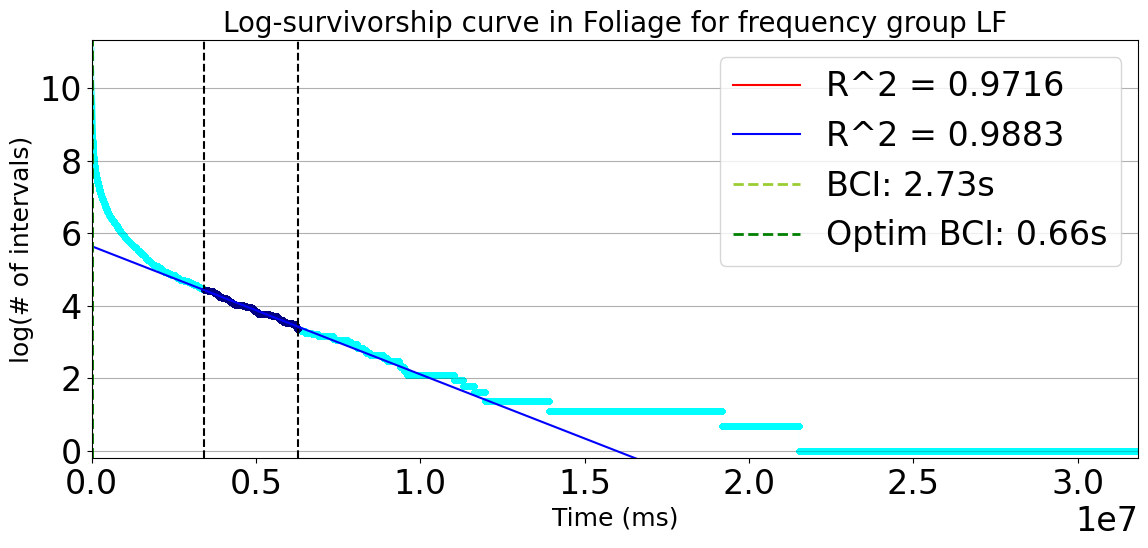

In [34]:
plt.figure(figsize=(12, 6))
if freq_key:
    plt.title(f"Log-survivorship curve in {site_name} for frequency group {freq_key.split('_')[0].upper()}", fontsize=20)
else:
    plt.title(f"Log-survivorship curve in {site_name} for all frequency groups", fontsize=20)
plt.plot(intervals_ms, survival, marker='.', c='cyan', alpha=0.1)
plt.plot(intervals_ms[fast_inds], survival[fast_inds], marker='.', c='navy')
plt.axvline(fast_start, linestyle='dashed', color='k')
plt.axvline(fast_end, linestyle='dashed', color='k')
x = np.linspace(-100, intervals_ms[-1], slow_end)
plt.plot(x, fast_coeff.intercept + fast_coeff.slope*x, c='red', marker=None, label=f"R^2 = {round(fast_coeff.rvalue**2, 4)}")
plt.plot(x, slow_coeff.intercept + slow_coeff.slope*x, c='blue', marker=None, label=f"R^2 = {round(slow_coeff.rvalue**2, 4)}")
plt.axvline(bci, linestyle='dashed', linewidth=2, color='yellowgreen', label=f"BCI: {round(bci/1000, 2)}s")
plt.axvline(optim_bci, linestyle='dashed', linewidth=2, color='green', label=f"Optim BCI: {round(optim_bci/1000, 2)}s")
plt.grid(axis='y')
plt.ylabel('log(# of intervals)', fontsize=18)
plt.xlabel('Time (ms)', fontsize=18)
plt.xlim(intervals_ms[0], fig_details['time_end'])
plt.ylim(survival[-1]-0.2, survival[0]+0.2)
plt.tight_layout()

plt.legend(loc='upper right')

plt.figure(figsize=(12, 6))
if freq_key:
    plt.title(f"Log-survivorship curve in {site_name} for frequency group {freq_key.split('_')[0].upper()}", fontsize=20)
else:
    plt.title(f"Log-survivorship curve in {site_name} for all frequency groups", fontsize=20)
plt.plot(intervals_ms, survival, marker='.', alpha=0.02, c='cyan')
plt.plot(intervals_ms[slow_inds], survival[slow_inds], marker='.', c='navy')
plt.axvline(slow_start, linestyle='dashed', color='k')
plt.axvline(slow_end, linestyle='dashed', color='k')
x = np.linspace(-100, intervals_ms[-1], slow_end)
plt.plot(x, fast_coeff.intercept + fast_coeff.slope*x, c='red', marker=None, label=f"R^2 = {round(fast_coeff.rvalue**2, 4)}")
plt.plot(x, slow_coeff.intercept + slow_coeff.slope*x, c='blue', marker=None, label=f"R^2 = {round(slow_coeff.rvalue**2, 4)}")
plt.axvline(bci, linestyle='dashed', linewidth=2, color='yellowgreen', label=f"BCI: {round(bci/1000, 2)}s")
plt.axvline(optim_bci, linestyle='dashed', linewidth=2, color='green', label=f"Optim BCI: {round(optim_bci/1000, 2)}s")
plt.grid(axis='y')
plt.ylabel('log(# of intervals)', fontsize=18)
plt.xlabel('Time (ms)', fontsize=18)
plt.xlim(intervals_ms[0], intervals_ms[-1])
plt.ylim(survival[-1]-0.2, survival[0]+0.2)
plt.tight_layout()

plt.legend(loc='upper right')
plt.show()